In [76]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Data from: https://physionet.org/content/mimiciii-demo/1.4/  
Details: https://mimic.physionet.org/mimictables/admissions/ and https://mit-lcp.github.io/mimic-schema-spy/

In [57]:
# Path to folder with data 
folder_path = "mimic-iii-clinical-database-demo-1.4/"



# Data 


pacient = pd.read_csv(folder_path+"PATIENTS.csv")
labevents = pd.read_csv(folder_path+"LABEVENTS.csv")
admissions = pd.read_csv(folder_path+"ADMISSIONS.csv")

In [59]:
#Clean admissions 

admissions_c=admissions.iloc[:,[1,2,3,6,7,10,11,12,13,9,8,17]]
admissions_c.admittime=pd.to_datetime(admissions_c.admittime)

# Zostawiam dane tylko z ostatniej wizyty w szpitalu 
admissions_c=admissions_c.iloc[admissions_c.groupby(["subject_id"]).admittime.idxmax(),:]

In [60]:
# Clean pacient 
pacient_c=pacient.iloc[:,[1,2,3,4,5,7]]

In [61]:
pacient_c

,subject_id,gender,dob,dod,dod_hosp,expire_flag
0,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,1
2,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,1
4,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1
...,...,...,...,...,...,...
95,44083,M,2057-11-15 00:00:00,2114-02-20 00:00:00,2114-02-20 00:00:00,1
96,44154,M,1878-05-14 00:00:00,2178-05-15 00:00:00,2178-05-15 00:00:00,1
97,44212,F,2078-06-16 00:00:00,2124-01-29 00:00:00,NaN,1
98,44222,M,2107-06-27 00:00:00,2182-08-03 00:00:00,2182-08-03 00:00:00,1


In [62]:
# Clean lab
labevents_c=labevents[-pd.isnull(labevents["hadm_id"])].iloc[:,[1,2,4,6,8]]
# Najpierw policzymy nieprawidłowe wyniki dla każdego pacjenta 
labevents_c = labevents_c.iloc[:,[0,1,4]]

labevents_c.flag = labevents_c.flag.apply(lambda x: x=="abnormal")

labevents_c=labevents_c.groupby(["subject_id","hadm_id",]).sum().reset_index()

In [63]:
# Łączenie 


# Najpierw wybieramy tylko wyniki dla ostatnich wizyt 


admission_labs=admissions_c.join(labevents_c,lsuffix="hadm_id",rsuffix="hadm_id").reset_index()


admission_labs.rename(columns={"subject_idhadm_id":"subject_id","hadm_idhadm_id":"hadm_id","flag":"flag_sum"},inplace=True)

# Ramka pacient 

admissin_lab_pacient = admission_labs.join(pacient_c,lsuffix="subject_id",rsuffix="subject_id")



In [64]:
admissin_lab_pacient=admissin_lab_pacient=admissin_lab_pacient.drop(admissin_lab_pacient.columns[[0,2,13,14,16,21]], axis=1)

In [70]:
# Finalne Dane
# Daty raczej kosz
# Można próbować albo z flag_sum (ale to ciężko) lepiej przewidywać albo gender, albo hospital_expire_flag ( umarł czy nie w szpitalu)

admissin_lab_pacient.head()

,admittime,admission_type,admission_location,language,religion,marital_status,ethnicity,insurance,discharge_location,hospital_expire_flag,flag_sum,gender,dob,dod,dod_hosp
0,2164-10-23 21:09:00,EMERGENCY,EMERGENCY ROOM ADMIT,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,Medicare,HOME HEALTH CARE,0,91,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00
1,2126-08-14 22:32:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,Private,DEAD/EXPIRED,1,250,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00
2,2125-10-04 23:36:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,Medicare,DEAD/EXPIRED,1,38,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00
3,2149-05-26 17:19:00,EMERGENCY,EMERGENCY ROOM ADMIT,NaN,CATHOLIC,DIVORCED,WHITE,Medicare,SNF,0,109,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN
4,2163-05-14 20:43:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,NaN,CATHOLIC,DIVORCED,WHITE,Medicare,DEAD/EXPIRED,1,142,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00


'discharge_location' and 'hospital_expire_flag' give the same data: if there is 'DEAD/EXPIRE' in  'discharge_location' then 'hospital_expire_flag' equals 1. That means we can drop 'discharge_location'.  
We can also drop columns with dates. 

In [71]:
admissin_lab_pacient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   admittime             100 non-null    datetime64[ns]
 1   admission_type        100 non-null    object        
 2   admission_location    100 non-null    object        
 3   language              57 non-null     object        
 4   religion              99 non-null     object        
 5   marital_status        85 non-null     object        
 6   ethnicity             100 non-null    object        
 7   insurance             100 non-null    object        
 8   discharge_location    100 non-null    object        
 9   hospital_expire_flag  100 non-null    int64         
 10  flag_sum              100 non-null    int64         
 11  gender                100 non-null    object        
 12  dob                   100 non-null    object        
 13  dod                  

In [75]:
admissin_lab_pacient['admission_location'].unique()

array(['EMERGENCY ROOM ADMIT', 'TRANSFER FROM HOSP/EXTRAM',
       'PHYS REFERRAL/NORMAL DELI', 'CLINIC REFERRAL/PREMATURE'],
      dtype=object)

# Preprocessing

## Encoding data

In [171]:
# In our DataFrame we have mostly categorical data. We can try to encode data to help us with creating ML models. 
# We will keep our encoded data in encoded_admissin_lab_pacient variable.
# We can also keep legend to what encoded value means in each category(encoding_legend variable). 
from sklearn.preprocessing import LabelEncoder
columns_to_encode = ["admission_type", "admission_location", "religion", "marital_status", "ethnicity", 
                     "insurance", "discharge_location", "gender", "language"]

encoded_admissin_lab_pacient = admissin_lab_pacient.copy()
encoding_legend = pd.DataFrame(columns=['value', 'column_name', 'encoded_value'])

le = LabelEncoder()

for column in columns_to_encode: 
    encoded_admissin_lab_pacient[column] = encoded_admissin_lab_pacient[column].astype(str)
    encoded_admissin_lab_pacient[column] = le.fit_transform(encoded_admissin_lab_pacient[column])
    
    encoding_legend = encoding_legend.append(pd.DataFrame({"value" : admissin_lab_pacient[column], 
                            "column_name" : column, 
                            "encoded_value" : encoded_admissin_lab_pacient[column]}), ignore_index=True)

encoded_admissin_lab_pacient.head()

,admittime,admission_type,admission_location,language,religion,marital_status,ethnicity,insurance,discharge_location,hospital_expire_flag,flag_sum,gender,dob,dod,dod_hosp
0,2164-10-23 21:09:00,1,1,5,1,2,2,2,3,0,91,0,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00
1,2126-08-14 22:32:00,1,3,5,1,3,7,3,0,1,250,0,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00
2,2125-10-04 23:36:00,1,3,5,1,6,7,2,0,1,38,0,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00
3,2149-05-26 17:19:00,1,1,5,1,0,8,2,9,0,109,0,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN
4,2163-05-14 20:43:00,1,3,5,1,0,8,2,0,1,142,1,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00


In [172]:
# We can drop colmns with dates and 'discharge_location'. 
encoded_admissin_lab_pacient = encoded_admissin_lab_pacient.drop(["admittime", "discharge_location", "dob", "dod", "dod_hosp"], axis=1)

## Test Train split

In [183]:
from sklearn.model_selection import train_test_split
alp_X_train, alp_X_test, alp_y_train, alp_y_test = train_test_split(
    encoded_admissin_lab_pacient.loc[:, encoded_admissin_lab_pacient.columns != 'hospital_expire_flag'], 
    encoded_admissin_lab_pacient['hospital_expire_flag'], 
    test_size=0.33, random_state=42)

print('Liczba obserwacji w zbiorze treningowym:', alp_X_train.shape[0])
print('Liczba obserwacji w zbiorze testowym:', alp_X_test.shape[0])

print('Liczba zmiennych w modelu:', alp_X_train.shape[1])

Liczba obserwacji w zbiorze treningowym: 67
Liczba obserwacji w zbiorze testowym: 33
Liczba zmiennych w modelu: 9


## Drzewa decyzyjne

[Text(181.35000000000002, 190.26, 'X[7] <= 241.0\ngini = 0.46\nsamples = 67\nvalue = [43, 24]'),
 Text(111.60000000000001, 135.9, 'X[3] <= 7.5\ngini = 0.393\nsamples = 52\nvalue = [38, 14]'),
 Text(55.800000000000004, 81.53999999999999, 'X[4] <= 5.5\ngini = 0.283\nsamples = 41\nvalue = [34, 7]'),
 Text(27.900000000000002, 27.180000000000007, 'gini = 0.229\nsamples = 38\nvalue = [33, 5]'),
 Text(83.7, 27.180000000000007, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(167.4, 81.53999999999999, 'X[7] <= 60.5\ngini = 0.463\nsamples = 11\nvalue = [4, 7]'),
 Text(139.5, 27.180000000000007, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(195.3, 27.180000000000007, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(251.10000000000002, 135.9, 'X[0] <= 0.5\ngini = 0.444\nsamples = 15\nvalue = [5, 10]'),
 Text(223.20000000000002, 81.53999999999999, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(279.0, 81.53999999999999, 'X[6] <= 1.5\ngini = 0.408\nsamples = 14\nvalue = [4, 10]'),
 Text(

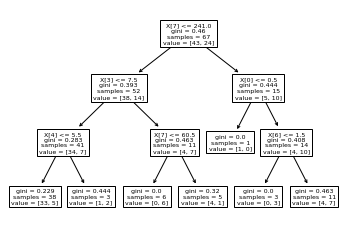

In [194]:
# We create decision tree classifier 
from sklearn.tree import DecisionTreeClassifier, plot_tree
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(
    alp_X_train, 
    alp_y_train)

predictions = decision_tree.predict_proba(alp_X_test)

plot_tree(decision_tree)

## Ocena jakości modelu

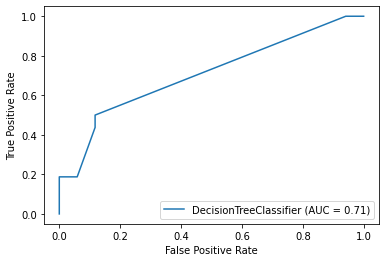

In [193]:
# Create ROC plot to decision tree
from sklearn import metrics
metrics.plot_roc_curve(decision_tree, alp_X_test, alp_y_test)